In [1]:
from transformer_utils.low_memory import enable_low_memory_load
import transformers

enable_low_memory_load() #without this model ends up on CPU?
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model = transformers.AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-125M')

c:\users\stephenprior\appdata\local\programs\python\python39\lib\site-packages\torch\nn\modules\lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [2]:
from src.visualization import visualize
text = "The forecast said that thunderstorm activity with the risk of hail will lead to localised"
tokens = visualize.text_to_input_ids(tokenizer, text)
expected_token_id = 17448
tokenizer.decode(expected_token_id)

' flooding'

In [3]:
targetLayer = model.transformer.h[11]
targetLayer

GPTNeoBlock(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPTNeoAttention(
    (attention): GPTNeoLocalSelfAttention(
      (attn_dropout): Dropout(p=0, inplace=False)
      (resid_dropout): Dropout(p=0, inplace=False)
      (k_proj): Linear(in_features=0, out_features=768, bias=False)
      (v_proj): Linear(in_features=0, out_features=768, bias=False)
      (q_proj): Linear(in_features=0, out_features=768, bias=False)
      (out_proj): Linear(in_features=0, out_features=768, bias=True)
    )
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPTNeoMLP(
    (c_fc): Linear(in_features=0, out_features=3072, bias=True)
    (c_proj): Linear(in_features=0, out_features=768, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
)

In [6]:
def forward_with_embeds(embeds):
    transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
    hidden_states = transformer_outputs[0]
    lm_logits = model.lm_head(hidden_states)
    return lm_logits[0,-1,expected_token_id:expected_token_id+1]


Looping through transformer layers starting closest to the output, it can be seen how influence spreads.

Close to the output attribution is almost entirely against the current position => lower layers.

Different positions become important and unimportant at different lower layers.


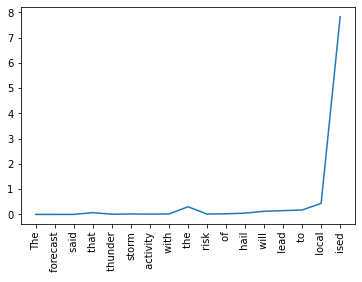

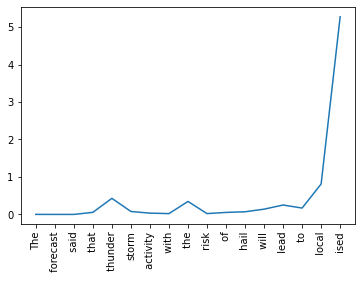

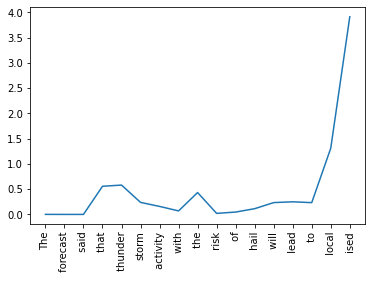

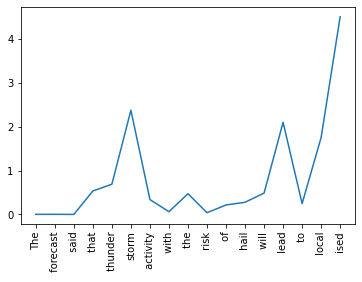

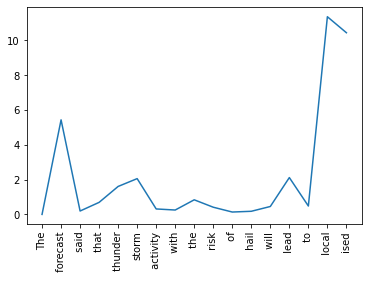

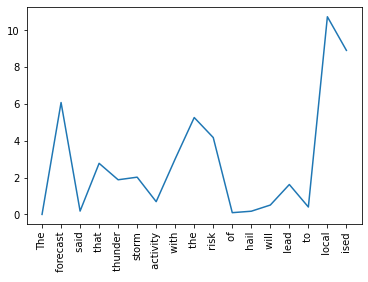

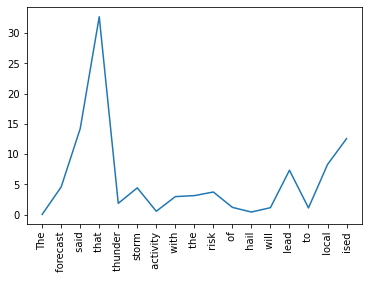

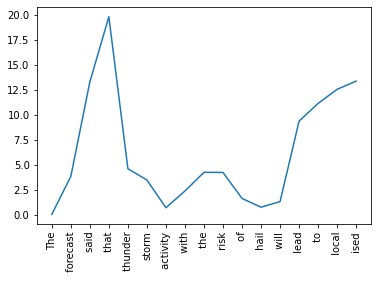

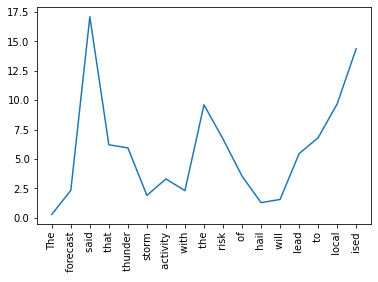

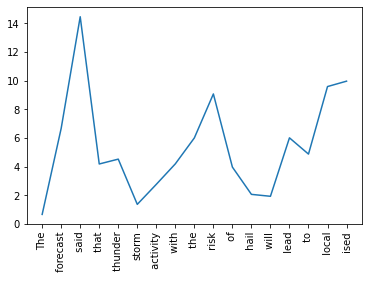

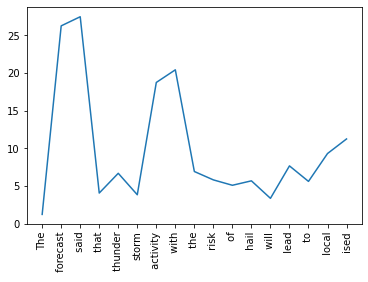

In [8]:
from captum.attr import LayerConductance
labels = [tokenizer.decode(token) for token in tokens[0]]

for i in range(11,0,-1):
    
    plt = visualize.plot_layer_attribution(model, tokens, labels, lc)
    plt.show()

These "waveforms" show the attribution of single vectors input to each transformer layer (in all cases attribution is to the predicted next token). The suspicion was that these might stack - certain neurons would become important in different layers, but would remain important to the top - but this doesn't appear to be the case.


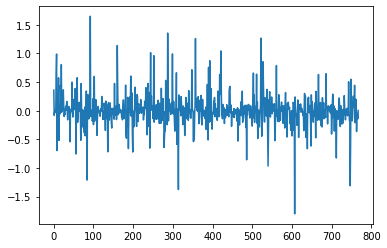

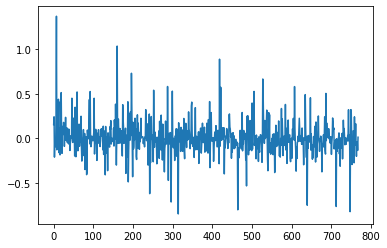

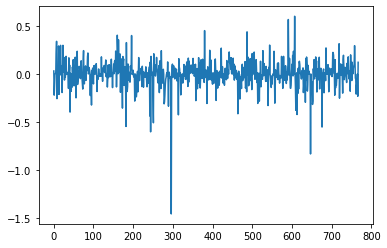

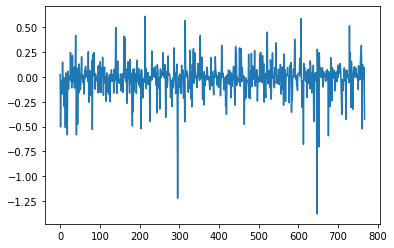

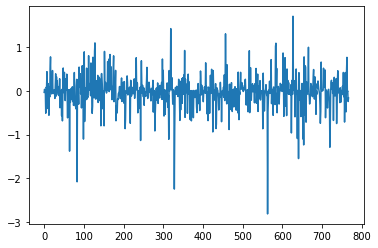

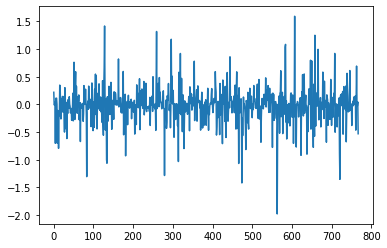

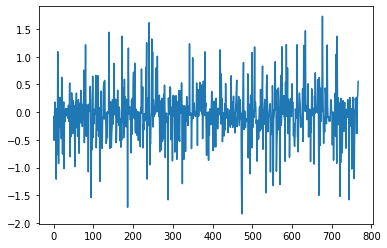

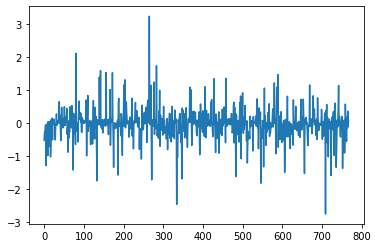

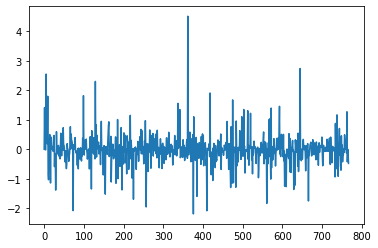

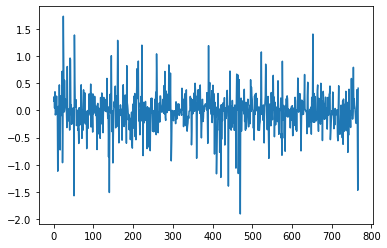

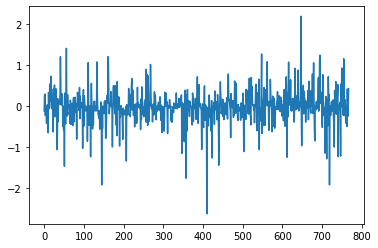

In [11]:
for i in range(11,0,-1):
    lc = LayerConductance(forward_with_embeds, model.transformer.h[i])
    embeds = model.transformer.wte(tokens)    
    embeds.requires_grad_()
    attr = lc.attribute(embeds, attribute_to_layer_input=True)#, target=expected_token_id)
    attr = attr.detach().cpu().numpy()
    plt.plot(attr[0,16])
    plt.show()